In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torchvision import transforms

from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print('Using device : {}'.format(device))

Using device : cuda:0


In [3]:
mnist_dataset = MNIST(
  './mnist',
  train = True,
  download = True,
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
  ])
)

print("Dataset size: ", len(mnist_dataset))

batch_size = 64

training_dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle = True)

Dataset size:  60000


In [4]:
images, label = next(iter(training_dataloader))

print('Image shape:', images.shape)
print('Label shape:', label.shape)

# print(images[0][0])

Image shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


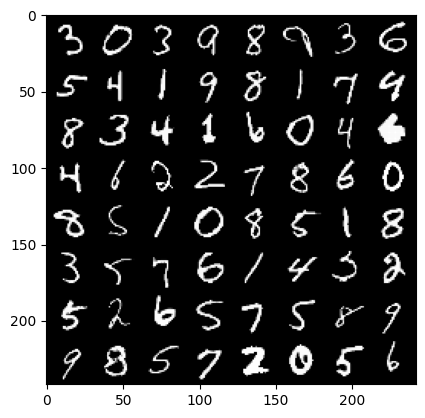

In [5]:
import matplotlib.pyplot as plt

image_grid = make_grid(images)

# print(image_grid.shape)

plt.imshow(image_grid.permute(1, 2, 0), cmap='gray')

In [6]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(100, 128),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Linear(128, 256),
      nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Linear(256, 512),
      nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Linear(512, 1024),
      nn.BatchNorm1d(1024, 0.8),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Linear(1024, 28 * 28),
      nn.Tanh()
    )

  def forward(self, x):
    img = self.model(x)
    return img.reshape(-1, 1, 28, 28)

In [7]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(28 * 28, 512),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace = True),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = x.reshape(-1, 28 * 28)
    return self.model(x)

In [8]:
# Loss function
bce_loss = nn.BCELoss().to(device)

# Initialize generator and discriminator
netG = Generator()
netD = Discriminator()

netG = netG.to(device)
netD = netD.to(device)


In [ ]:

num_epochs = 100

# Optimizers
optimizer_G = torch.optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))

# tbar = tqdm(training_dataloader)
tbar = training_dataloader

LOAD_EPOCH = 99

start_epoch = 0

if LOAD_EPOCH:
  checkpoint = torch.load('checkpoints/gan_{}.pth'.format(LOAD_EPOCH))
  netG.load_state_dict(checkpoint['model_state_dict'])
  netD.load_state_dict(checkpoint['discriminator_state_dict'])
  start_epoch = checkpoint['epochs'] + 1
  optimizer_G.load_state_dict(checkpoint['optimizer_G'])
  optimizer_D.load_state_dict(checkpoint['optimizer_D'])

netG.train()
netD.train()

for epoch in range(start_epoch, start_epoch + num_epochs):
  for index, (image, label) in enumerate(tbar):
    # Adversarial ground truths
    batch_size = image.shape[0]
    valid = torch.ones((batch_size, 1), requires_grad = False)
    fake = torch.zeros((batch_size, 1), requires_grad = False)

    # Noise input to generator.
    z = torch.randn((batch_size, 100), requires_grad = False)
    optimizer_D.zero_grad()

    valid = valid.to(device)
    fake = fake.to(device)
    z = z.to(device)
    image = image.to(device)
    generated = netG(z)

    # Train Generator
    optimizer_G.zero_grad()
    g_loss = bce_loss(netD(generated), valid)

    g_loss.backward()
    optimizer_G.step()

    # Train discriminator
    real_loss = bce_loss(netD(image), valid)
    fake_loss = bce_loss(netD(generated.detach()), fake)

    d_loss = (real_loss + fake_loss) / 2.

    d_loss.backward()
    optimizer_D.step()

    # tbar.set_description(
    #   "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
    #   % (epoch, num_epochs, index, len(training_dataloader), d_loss.item(), g_loss.item())
    # )
    print(
      "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
      % (epoch, num_epochs, index, len(training_dataloader), d_loss.item(), g_loss.item())
    )
    # tbar.update()

    if index == len(training_dataloader) - 1:
      save_image(generated[:25], "results/%d.png" % epoch, nrow = 5, normalize = True)


  torch.save({
    'epochs': epoch,
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
    'model_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
  }, 'checkpoints/gan_{}.pth'.format(epoch))

[Epoch 100/100] [Batch 0/938] [D loss: 0.734264] [G loss: 0.298840]
[Epoch 100/100] [Batch 1/938] [D loss: 0.576182] [G loss: 0.476999]
[Epoch 100/100] [Batch 2/938] [D loss: 0.813393] [G loss: 0.248809]
[Epoch 100/100] [Batch 3/938] [D loss: 0.586030] [G loss: 0.455424]
[Epoch 100/100] [Batch 4/938] [D loss: 0.716030] [G loss: 0.327797]
[Epoch 100/100] [Batch 5/938] [D loss: 0.686518] [G loss: 0.337331]
[Epoch 100/100] [Batch 6/938] [D loss: 0.639567] [G loss: 0.395856]
[Epoch 100/100] [Batch 7/938] [D loss: 0.683309] [G loss: 0.339391]
[Epoch 100/100] [Batch 8/938] [D loss: 0.646845] [G loss: 0.390451]
[Epoch 100/100] [Batch 9/938] [D loss: 0.752576] [G loss: 0.286341]
[Epoch 100/100] [Batch 10/938] [D loss: 0.589716] [G loss: 0.442411]
[Epoch 100/100] [Batch 11/938] [D loss: 0.751465] [G loss: 0.293137]
[Epoch 100/100] [Batch 12/938] [D loss: 0.620297] [G loss: 0.411439]
[Epoch 100/100] [Batch 13/938] [D loss: 0.715766] [G loss: 0.323919]
[Epoch 100/100] [Batch 14/938] [D loss: 0.62

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])


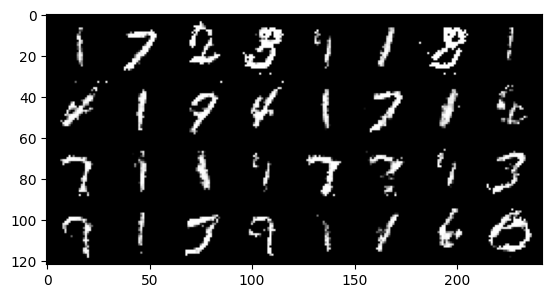

In [9]:
checkpoint = torch.load('checkpoints/gan_199.pth')

netG.load_state_dict(checkpoint['model_state_dict'])

netG.eval()

z = torch.randn(batch_size, 100).to(device)

result = netG(z)

print(result.shape)
plt.imshow(make_grid(result.cpu()[:32]).permute(1, 2, 0))